In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("Imputed.csv")

col_to_fix = df.select_dtypes(include='object').columns.tolist()

for col in col_to_fix:
    if col != "Provinsi":
        df[col] = df[col].astype(str)
        df[col] = df[col].str.replace(",", ".", regex=False) # koma jadi titik
        df[col] = df[col].str.replace(" ", "", regex=False)
        df[col] = df[col].replace("-", np.nan) 
        df[col] = df[col].astype(float)   

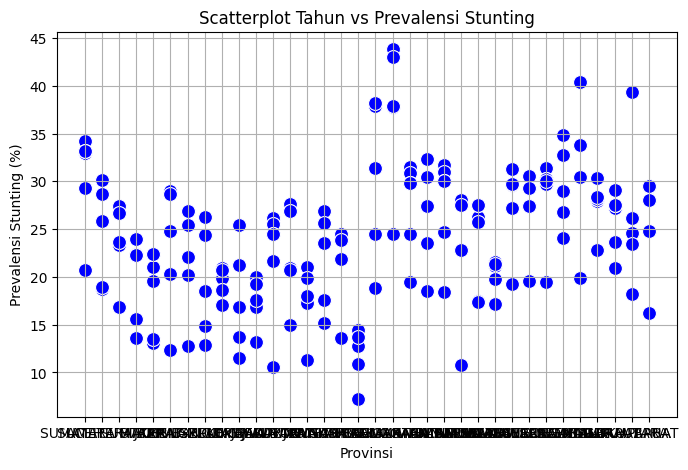

In [3]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Provinsi', y='Stunting', color='blue', s=100)

plt.title('Scatterplot Tahun vs Prevalensi Stunting')
plt.xlabel('Provinsi')
plt.ylabel('Prevalensi Stunting (%)')
plt.grid(True)
plt.show()

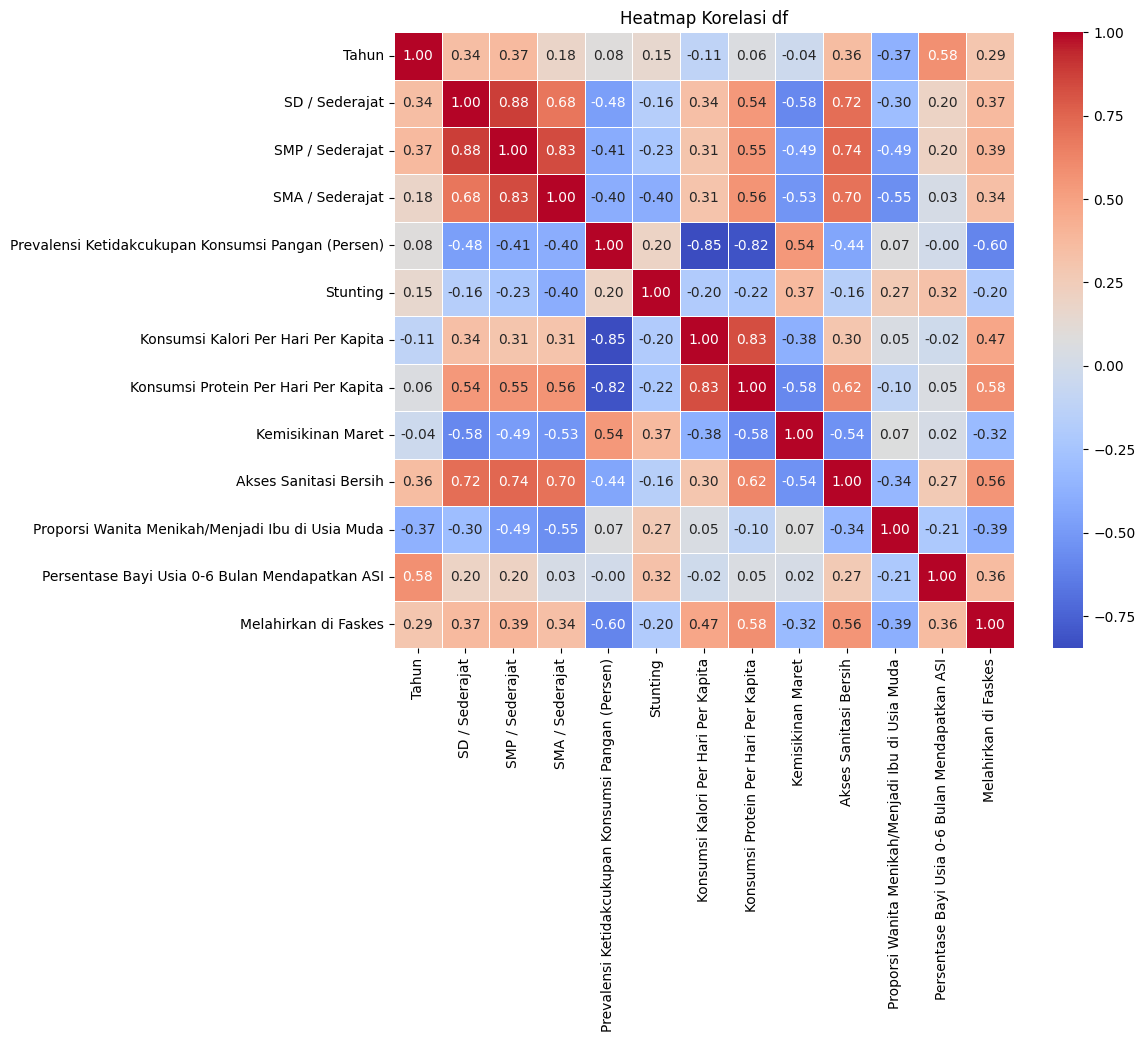

In [4]:
corr = df.corr(numeric_only=True)

# Buat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Judul (opsional)
plt.title('Heatmap Korelasi df')

# Tampilkan plot
plt.show()

In [5]:
import numpy as np
df = df.drop(["Provinsi","Tahun"], axis = 1)
def correlation(kol_df, threshold):
    corr_col = set()
    corr_matrix = kol_df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if np.abs(corr_matrix.iloc[i, j]) > threshold:
                corr_col.add(corr_matrix.columns[j])
    return corr_col

corr_col = correlation(df, threshold=0.8)
df = df.drop(columns = corr_col, axis = 1)
print(df.columns)

Index(['SD / Sederajat', 'Prevalensi Ketidakcukupan Konsumsi Pangan (Persen)',
       'Stunting', 'Kemisikinan Maret', 'Akses Sanitasi Bersih',
       'Proporsi Wanita Menikah/Menjadi Ibu di Usia Muda',
       'Persentase Bayi Usia 0-6 Bulan Mendapatkan ASI',
       'Melahirkan di Faskes'],
      dtype='object')


In [6]:
from scipy.stats import pearsonr

numerical_cols = df.select_dtypes(include='number').columns.tolist()
numerical_cols.remove('Stunting')

# Simpan hasil Pearson correlation
results = {}

for col in numerical_cols:
    corr, p_value = pearsonr(df[col], df['Stunting'])
    results[col] = {'pearson_r': corr, 'p_value': p_value}

# Ubah jadi DataFrame untuk lebih rapi
results_df = pd.DataFrame(results).T
print(results_df)

                                                    pearson_r       p_value
SD / Sederajat                                      -0.162783  2.000518e-02
Prevalensi Ketidakcukupan Konsumsi Pangan (Persen)   0.198497  4.426469e-03
Kemisikinan Maret                                    0.371617  4.440467e-08
Akses Sanitasi Bersih                               -0.159629  2.257284e-02
Proporsi Wanita Menikah/Menjadi Ibu di Usia Muda     0.268732  1.017380e-04
Persentase Bayi Usia 0-6 Bulan Mendapatkan ASI       0.324848  2.132498e-06
Melahirkan di Faskes                                -0.195173  5.150650e-03


In [7]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

y = df["Stunting"]
X = df.drop("Stunting", axis=1)

# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train = scaler_X.fit_transform(X_train)
# X_val = scaler_X.transform(X_val)

# y_train = y_train.values.reshape(-1, 1)
# y_val = y_val.values.reshape(-1, 1)

# X_train = X_train.astype(np.float32)
# X_val = X_val.astype(np.float32)
# y_train = y_train.astype(np.float32)
# y_val = y_val.astype(np.float32)


# TabPFN 

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from tabpfn import TabPFNRegressor  # Pastikan sudah install: pip install tabpfn
from sklearn.metrics import make_scorer, mean_absolute_error

# Inisialisasi model TabPFN
tabpfn_model = TabPFNRegressor(device='cpu')  # Ganti 'cpu' ke 'cuda' jika pakai GPU

# K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Skor MAE (negatif agar kompatibel dengan cross_val_score)
neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Cross-validation
scores = cross_val_score(tabpfn_model, X, y, scoring=neg_mae_scorer, cv=kf)
mae_scores = -scores  # Konversi ke positif

# Simpan ke CSV
df_scores = pd.DataFrame({
    'Fold': [f'Fold_{i+1}' for i in range(len(mae_scores))],
    'MAE': mae_scores
})
df_scores.loc[len(df_scores.index)] = ['Mean', mae_scores.mean()]
df_scores.to_csv('tabpfn_POLOS.csv', index=False)

print("Hasil cross-validation disimpan di 'tabpfn_POLOS.csv'")


Hasil cross-validation disimpan di 'tabpfn_POLOS.csv'
